## Introduction

Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry. The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification. The model will help to optimize the production and eliminate unprofitable parameters.

Mined ore undergoes primary processing to get the ore mixture or rougher feed, which is the raw material for flotation (also known as the rougher process). After flotation, the material is sent to two-stage purification.

1. Flotation

Gold ore mixture is fed into the float banks to obtain rougher Au concentrate and rougher tails (product residues with a low concentration of valuable metals).
The stability of this process is affected by the volatile and non-optimal physicochemical state of the flotation pulp (a mixture of solid particles and liquid).

2. Purification

The rougher concentrate undergoes two stages of purification. After purification, we have the final concentrate and new tails.

We need to predict two values:

- rougher concentrate recovery `rougher.output.recovery`
- final concentrate recovery `final.output.recovery`

Evaluation metric: symmetric Mean Absolute Percentage Error (sMAPE)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import cross_val_score

In [2]:
# Read in the dataset
df_train = pd.read_csv('datasets/gold_recovery_train.csv')
df_test = pd.read_csv('datasets/gold_recovery_test.csv')
df_full = pd.read_csv('datasets/gold_recovery_full.csv')

In [3]:
# Convert date to datetime
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')

<b>Task 1.2:</b>

Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

In [4]:
# Recovery = C * (F - T)  /   F * (C - T) * 100%
# C share of gold in the concentrate right after flotation (rougher.output.concentrate_au)
# F share of gold in the feed before flotation (rougher.input.feed_au)
# T share of gold in the rougher tails right after flotation (rougher.output.tail_au)

num = df_train['rougher.output.concentrate_au'] * (df_train['rougher.input.feed_au'] - df_train['rougher.output.tail_au'])
denom = df_train['rougher.input.feed_au'] * (df_train['rougher.output.concentrate_au'] - df_train['rougher.output.tail_au'])
recovery_calc = num / denom * 100

In [5]:
# Actual rougher.output.recovery values
recovery = df_train['rougher.output.recovery']

In [6]:
# MAE calculation
mae_recovery = np.abs(recovery_calc - recovery).sum() / len(recovery)
print(f'MAE for calculated rougher.output.recovery feature is: {mae_recovery}')

MAE for calculated rougher.output.recovery feature is: 7.883623897364653e-15


The MAE between the calculation and the feature values for `rougher.output.recovery` in the training set is 7.88e-15 or essentially 0, meaning that the calculations are essentially spot on to the recovery values and that recovery is calculated correctly.

<b>Task 1.3:</b>

Analyze the features not available in the test set. What are these parameters? What is their type?

In [7]:
# Display the test set information
df_test.info()
display(df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5554 non-null   float64       
 2   primary_cleaner.input.depressant            5572 non-null   float64       
 3   primary_cleaner.input.feed_size             5856 non-null   float64       
 4   primary_cleaner.input.xanthate              5690 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64       
 9   primary_

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [8]:
# Difference in columns between train and test set
cols_difference = df_train.columns.difference(df_test.columns).tolist()
print(cols_difference)

['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au', 'final.output.tail_pb', 'final.output.tail_sol', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol', 'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.recovery', 'rougher.output.tail_ag', 'rougher.output.tail_au', 'rougher.output.tail_pb', 'rougher.output.tail

The features that are not included in the test set are all 'output' and 'calculation' types. These are likely parameters that are calculated from the measured data, and should be removed prior to training models.

<b>Task 1.4:</b> 

Perform data preprocessing.

In [9]:
# Investigate missing values on train set
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                16860 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         16788 non-null  float64       
 2   final.output.concentrate_pb                         16788 non-null  float64       
 3   final.output.concentrate_sol                        16490 non-null  float64       
 4   final.output.concentrate_au                         16789 non-null  float64       
 5   final.output.recovery                               15339 non-null  float64       
 6   final.output.tail_ag                                16794 non-null  float64       
 7   final.output.tail_pb                                16677 non-null  float64       
 8   final.

In [10]:
# Using forward fill to fill in missing feature values
cols_to_avoid = ['final.output.recovery', 'rougher.output.recovery']
for item in df_train:
    if item not in cols_to_avoid:
        df_train[item] = df_train[item].ffill(axis = 0)

In [11]:
# Look at the missing values for targets
df_train[['final.output.recovery', 'rougher.output.recovery']].isna().agg(['mean', 'sum'])

,final.output.recovery,rougher.output.recovery
mean,0.090214,0.15261
sum,1521.000000,2573.00000


Even though the missing values for the targets represent a good amount of the data set, these rows will need to be removed. We need to know how well the predictions match the target values.

In [12]:
# Dropping rows with missing values for targets
df_train.dropna(subset=['final.output.recovery', 'rougher.output.recovery'], inplace=True)

In [13]:
# Storing the targets to be predicted
df_train_target_rougher_recovery = df_train['rougher.output.recovery']
df_train_target_final_recovery = df_train['final.output.recovery']

In [14]:
# Dropping columns (difference from train and test set) 
df_train_features = df_train.drop(cols_difference, axis=1)
df_train_features.drop('date', axis=1, inplace=True)

In [15]:
# Check to confirm changes
df_train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               14149 non-null  float64
 1   primary_cleaner.input.depressant            14149 non-null  float64
 2   primary_cleaner.input.feed_size             14149 non-null  float64
 3   primary_cleaner.input.xanthate              14149 non-null  float64
 4   primary_cleaner.state.floatbank8_a_air      14149 non-null  float64
 5   primary_cleaner.state.floatbank8_a_level    14149 non-null  float64
 6   primary_cleaner.state.floatbank8_b_air      14149 non-null  float64
 7   primary_cleaner.state.floatbank8_b_level    14149 non-null  float64
 8   primary_cleaner.state.floatbank8_c_air      14149 non-null  float64
 9   primary_cleaner.state.floatbank8_c_level    14149 non-null  float64
 10  primary_cl

In [16]:
# Prep the test set
# Grab the target parameters from the full csv file and merge
# Split into features and target

# merging dataframe from full csv file to merge into the test set
merging_df = df_full.loc[:, ['date', 'final.output.recovery', 'rougher.output.recovery']]

# Merge left into test data set
test_merged = df_test.merge(merging_df, on='date', how='left')

In [17]:
# Check missing target values
test_merged[['rougher.output.recovery', 'final.output.recovery']].isna().agg(['mean', 'sum'])

,rougher.output.recovery,final.output.recovery
mean,0.093238,0.075478
sum,546.000000,442.000000


In [18]:
# forward fill on test set for missing data
for item in test_merged:
    if item not in cols_to_avoid:
        test_merged[item] = test_merged[item].ffill(axis = 0)

In [19]:
# Remove missing target rows
test_merged.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)

In [20]:
# Store target values
df_test_target_final_recovery = test_merged['final.output.recovery']
df_test_target_rougher_recovery = test_merged['rougher.output.recovery']

In [21]:
# Strip features
df_test_features = test_merged.drop(['date', 'final.output.recovery', 'rougher.output.recovery'], axis=1)
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5855
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5290 non-null   float64
 1   primary_cleaner.input.depressant            5290 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5290 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null   float64
 10  primary_clea

## Data analysis

<b>Task 2.1</b>

Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

In [ ]:
# concentration of metals:
# rougher.input.feed_XX
# rougher.output.concentrate_XX
# rougher.output.concentrate_XX
# rougher.output.concentration_XX

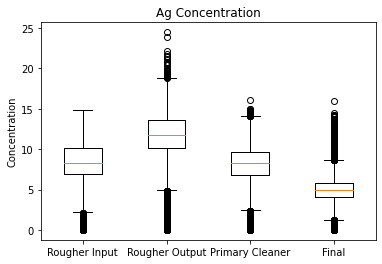

In [22]:
# Boxplots to show concentration of metals
fig, ax = plt.subplots()
ag_rougher_input = df_full['rougher.input.feed_ag'].dropna()
ag_rougher_conc = df_full['rougher.output.concentrate_ag'].dropna()
ag_prim_cleaner_conc = df_full['primary_cleaner.output.concentrate_ag'].dropna()
ag_final_conc = df_full['final.output.concentrate_ag'].dropna()
ax.boxplot([ag_rougher_input, ag_rougher_conc, ag_prim_cleaner_conc, ag_final_conc])
plt.xticks([1, 2, 3, 4], ['Rougher Input', 'Rougher Output', 'Primary Cleaner', 'Final'])
plt.title('Ag Concentration')
plt.ylabel('Concentration')
plt.show()

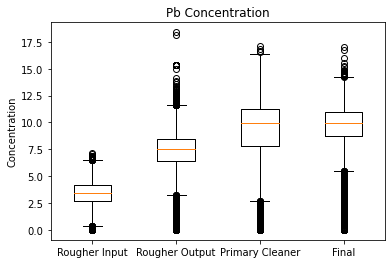

In [23]:
# Boxplots to show concentration of metals
fig, ax = plt.subplots()
pb_rougher_input = df_full['rougher.input.feed_pb'].dropna()
pb_rougher_conc = df_full['rougher.output.concentrate_pb'].dropna()
pb_prim_cleaner_conc = df_full['primary_cleaner.output.concentrate_pb'].dropna()
pb_final_conc = df_full['final.output.concentrate_pb'].dropna()
ax.boxplot([pb_rougher_input, pb_rougher_conc, pb_prim_cleaner_conc, pb_final_conc])
plt.xticks([1, 2, 3, 4], ['Rougher Input', 'Rougher Output', 'Primary Cleaner', 'Final'])
plt.title('Pb Concentration')
plt.ylabel('Concentration')
plt.show()

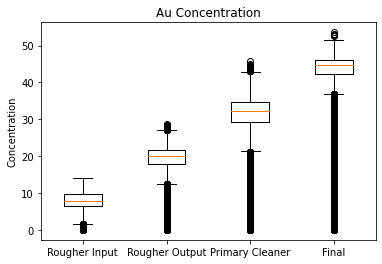

In [24]:
# Boxplots to show concentration of metals
fig, ax = plt.subplots()
au_rougher_input = df_full['rougher.input.feed_au'].dropna()
au_rougher_conc = df_full['rougher.output.concentrate_au'].dropna()
au_prim_cleaner_conc = df_full['primary_cleaner.output.concentrate_au'].dropna()
au_final_conc = df_full['final.output.concentrate_au'].dropna()
ax.boxplot([au_rougher_input, au_rougher_conc, au_prim_cleaner_conc, au_final_conc])
plt.xticks([1, 2, 3, 4], ['Rougher Input', 'Rougher Output', 'Primary Cleaner', 'Final'])
plt.title('Au Concentration')
plt.ylabel('Concentration')
plt.show()

Silver (Ag) concentration is reduced throughout each step of the the purification process. Lead (Pb) concentration appears to be increasing throughout the process. And gold (Au) concentration increases during each step of the purification process.

<b>Task 2.2:</b>

Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

In [25]:
# rougher.input.feed_size

# Train set description on input feed particle size
df_train['rougher.input.feed_size'].describe()

count    14149.000000
mean        61.247144
std         26.840517
min          9.659576
25%         48.966751
50%         55.424967
75%         66.341673
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [26]:
# Test set description on input feed particle size
df_test['rougher.input.feed_size'].describe()

count    5834.000000
mean       55.937535
std        22.724254
min         0.046369
25%        43.890852
50%        50.002004
75%        61.638434
max       477.445473
Name: rougher.input.feed_size, dtype: float64

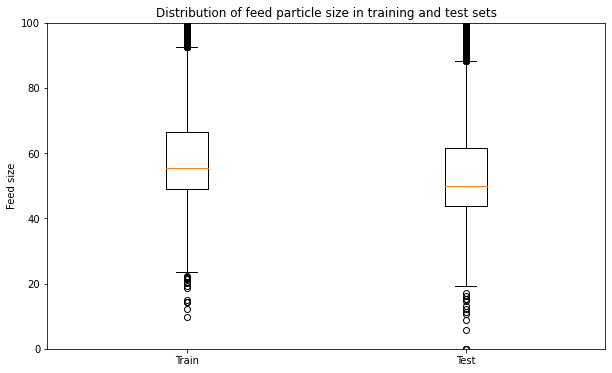

In [27]:
# Comparing distributions of the train and test set by boxplot
plt.figure(figsize=(10,6))
plt.boxplot([df_train['rougher.input.feed_size'].dropna(), df_test['rougher.input.feed_size'].dropna()])
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim(0, 100)
plt.ylabel('Feed size')
plt.title('Distribution of feed particle size in training and test sets')
plt.show()

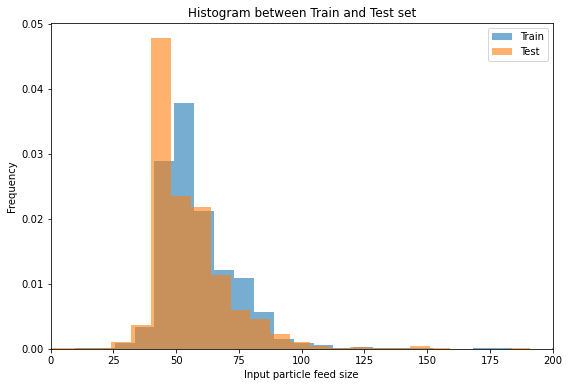

In [28]:
# Comparing between train and test by histogram
df_train['rougher.input.feed_size'].plot(kind='hist', density=True, bins=60, alpha=0.6, figsize=(9,6))
df_test['rougher.input.feed_size'].plot(kind='hist', density=True, bins=60, alpha=0.6)
plt.xlim(0, 200)
plt.legend(['Train', 'Test'])
plt.title('Histogram between Train and Test set')
plt.xlabel('Input particle feed size')
plt.show()

Comparing the train and test set by boxplots or histogram, it seems that its possible that the distribution is similar enough to each other.

<b>Task 2.3:</b> 

Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.

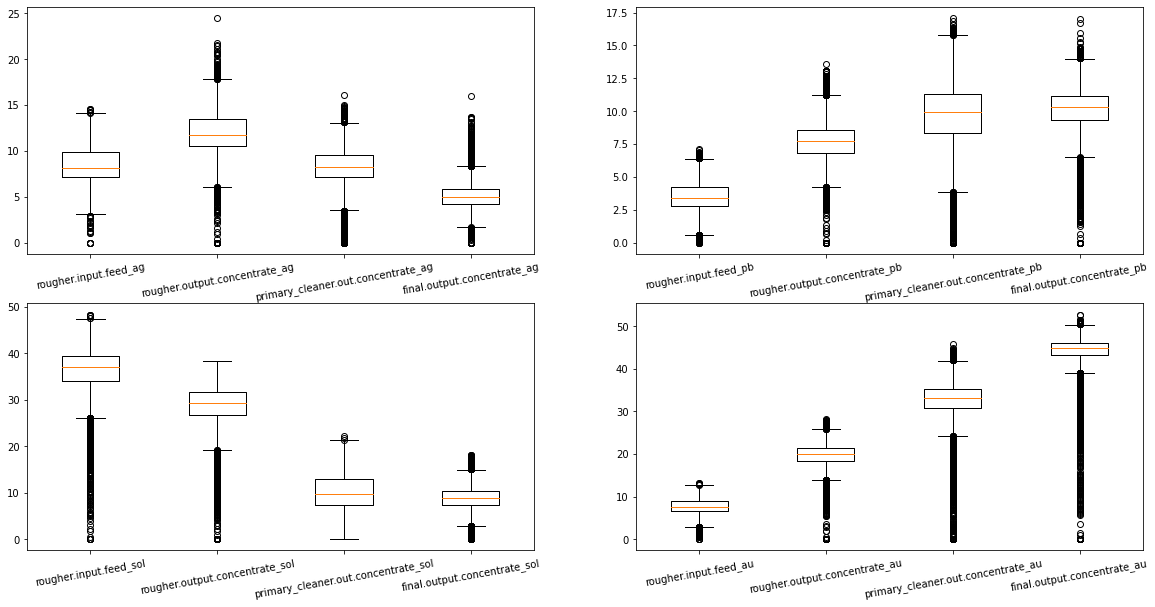

In [29]:
# rougher.input.feed_ag / pb / sol / au
# rougher.output.concentrate_ag
# primary_cleaner.output.concentrate_ag
# final.output.concentrate_ag

# Plot distributions of the different substances
fig, ax = plt.subplots(2, 2, figsize=(20,10))
ax[0, 0].boxplot([df_train['rougher.input.feed_ag'].dropna(), df_train['rougher.output.concentrate_ag'].dropna(), df_train['primary_cleaner.output.concentrate_ag'].dropna(), df_train['final.output.concentrate_ag'].dropna()])
ax[0, 0].set_xticklabels(['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.out.concentrate_ag', 'final.output.concentrate_ag'], rotation=10)

ax[0, 1].boxplot([df_train['rougher.input.feed_pb'].dropna(), df_train['rougher.output.concentrate_pb'].dropna(), df_train['primary_cleaner.output.concentrate_pb'].dropna(), df_train['final.output.concentrate_pb'].dropna()])
ax[0, 1].set_xticklabels(['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.out.concentrate_pb', 'final.output.concentrate_pb'], rotation=10)

ax[1, 0].boxplot([df_train['rougher.input.feed_sol'].dropna(), df_train['rougher.output.concentrate_sol'].dropna(), df_train['primary_cleaner.output.concentrate_sol'].dropna(), df_train['final.output.concentrate_sol'].dropna()])
ax[1, 0].set_xticklabels(['rougher.input.feed_sol', 'rougher.output.concentrate_sol', 'primary_cleaner.out.concentrate_sol', 'final.output.concentrate_sol'], rotation=10)

ax[1, 1].boxplot([df_train['rougher.input.feed_au'].dropna(), df_train['rougher.output.concentrate_au'].dropna(), df_train['primary_cleaner.output.concentrate_au'].dropna(), df_train['final.output.concentrate_au'].dropna()])
ax[1, 1].set_xticklabels(['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.out.concentrate_au', 'final.output.concentrate_au'], rotation=10)
plt.show()

In [30]:
# Function for plotting each histogram distributions
def plot_hist(element, title):
    fig, ax = plt.subplots(2, 2, figsize=(15,8))
    ax[0, 0].hist(df_train['rougher.input.feed_' + element], bins=100)
    ax[0, 0].set_xlabel('rougher.input.feed')
    ax[0, 0].set_ylabel('Frequency')

    ax[0, 1].hist(df_train['rougher.output.concentrate_' + element], bins=100)
    ax[0, 1].set_xlabel('rougher.output.concentrate')
    ax[0, 1].set_ylabel('Frequency')

    ax[1, 0].hist(df_train['primary_cleaner.output.concentrate_' + element], bins=100)
    ax[1, 0].set_xlabel('primary_cleaner.output.concentrate')
    ax[1, 0].set_ylabel('Frequency')

    ax[1, 1].hist(df_train['final.output.concentrate_' + element], bins=100)
    ax[1, 1].set_xlabel('final.output.concentrate')
    ax[1, 1].set_ylabel('Frequency')
    fig.suptitle(title)
    plt.show()

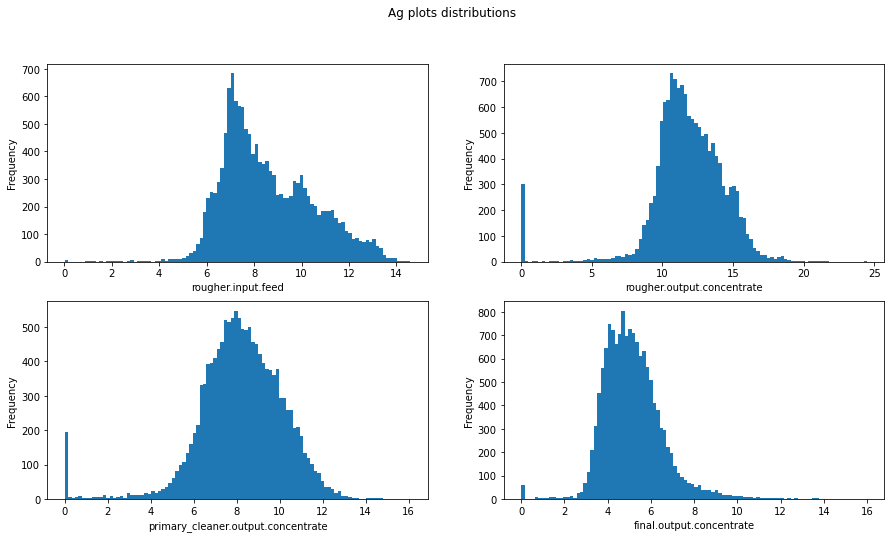

In [31]:
# Plotting histograms for Ag
plot_hist('ag', 'Ag plots distributions')

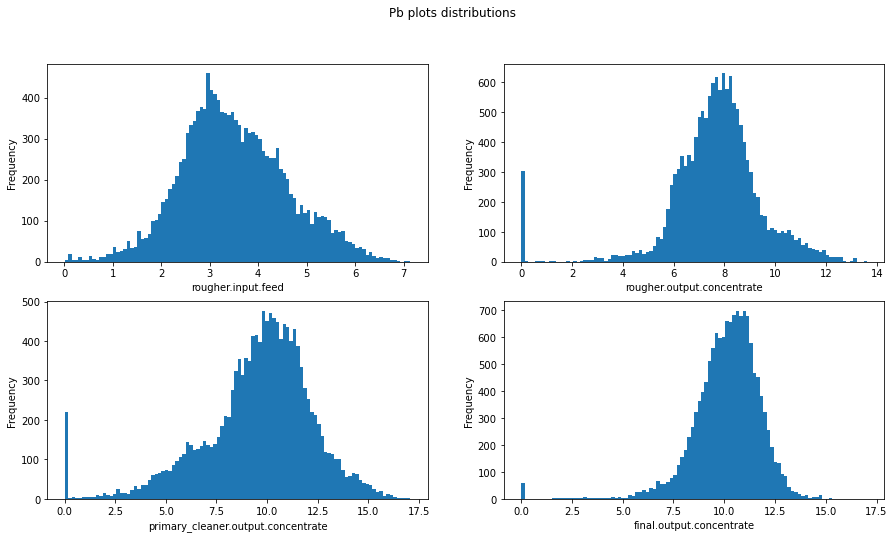

In [32]:
# Plotting histograms for Pb
plot_hist('pb', 'Pb plots distributions')

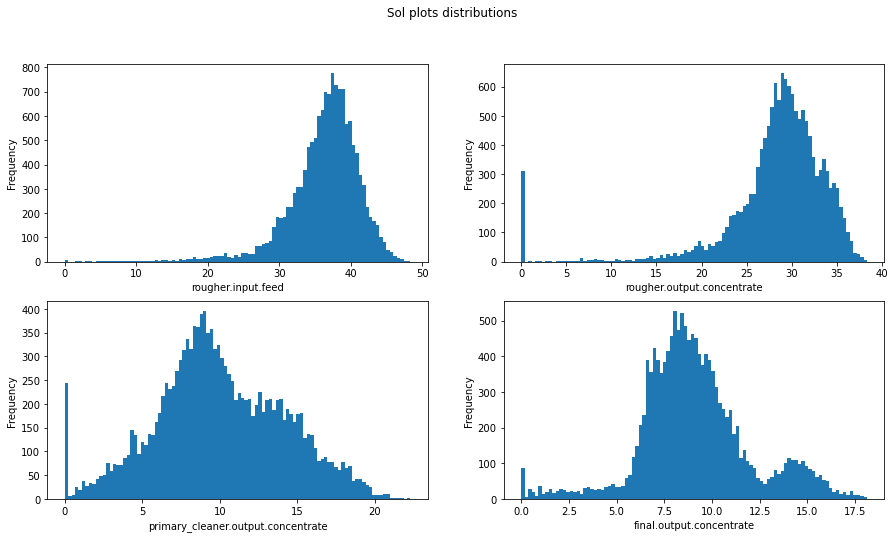

In [33]:
# Plotting histograms for sol
plot_hist('sol', 'Sol plots distributions')

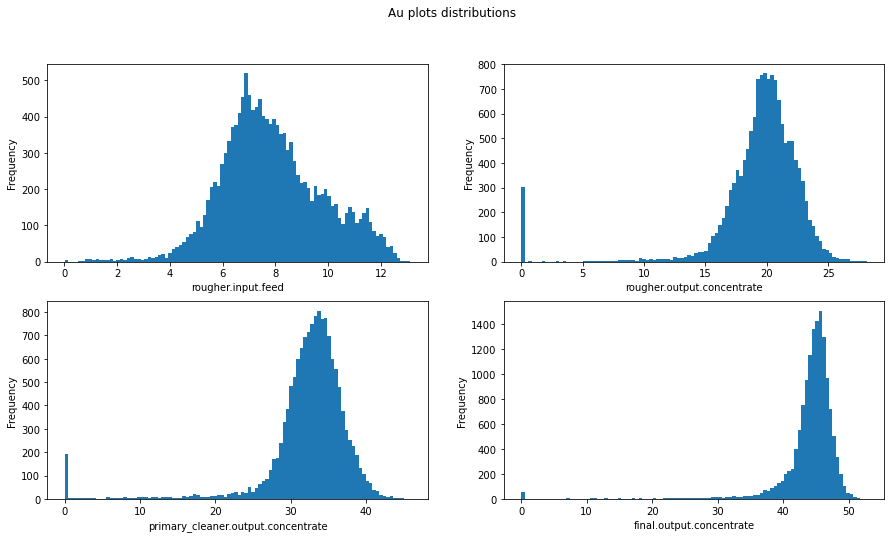

In [34]:
# Plotting histograms for au
plot_hist('au', 'Au plots distributions')

In the `output.concentrate` features, there are a considerable number of observations with a calculated output concentration of '0'. It is unknown how these values are calculated and possible that there are times where the input of the particular metal is '0' and can not yet be considered an anomaly.

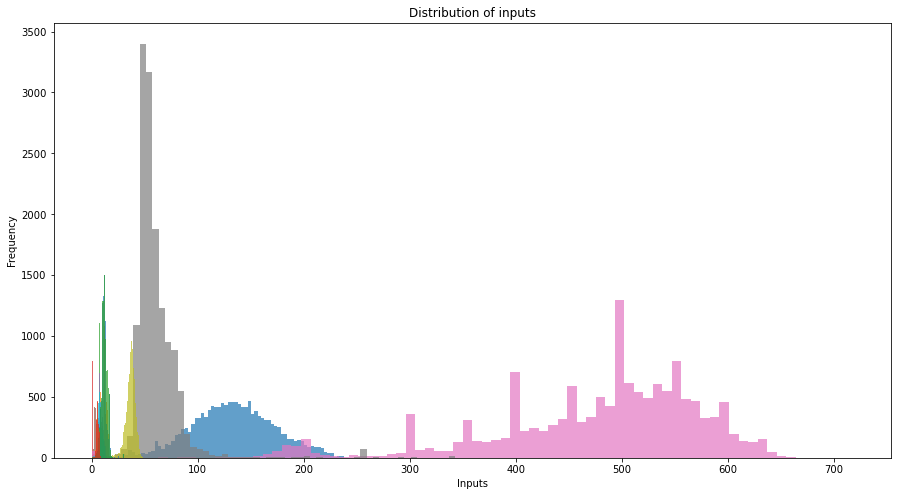

In [35]:
# Analyze the distribution of the inputs
inputs = df_train.loc[:, df_train.columns.str.contains('input')]
plt.figure(figsize=(15,8))
for input in inputs:
    plt.hist(df_train[input], bins=80, alpha=0.7)
plt.xlabel('Inputs')
plt.ylabel('Frequency')
plt.title('Distribution of inputs')
plt.show()

`Input` parameters doesn't appear to have anomalies in the distributions.

## Build the model

<b>Task 3.1:</b>

Write a function to calculate the final sMAPE value.

In [36]:
# function to calculate smape
def smape(target, prediction):
    metric = (abs(target-prediction) / ((abs(target) + abs(prediction)) / 2)).sum() / len(target)
    return metric * 100

In [37]:
# function to calculate final smape
def final_smape(smape_rougher, smape_final):
    return (0.25 * smape_rougher) + (0.75 * smape_final)

In [38]:
# start with predicting rougher.output.recovery
# features: df_train_features
# target: df_train_target_rougher_recovery

# cols to drop for rougher recovery
# need to get rid of all the purification states, secondary_cleaner and primary_cleaner because that comes after
rougher_train_features = df_train_features
rougher_train_features = rougher_train_features.loc[:, ~rougher_train_features.columns.str.startswith('primary')]
rougher_train_features = rougher_train_features.loc[:, ~rougher_train_features.columns.str.startswith('secondary')]
rougher_train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   rougher.input.feed_ag               14149 non-null  float64
 1   rougher.input.feed_pb               14149 non-null  float64
 2   rougher.input.feed_rate             14149 non-null  float64
 3   rougher.input.feed_size             14149 non-null  float64
 4   rougher.input.feed_sol              14149 non-null  float64
 5   rougher.input.feed_au               14149 non-null  float64
 6   rougher.input.floatbank10_sulfate   14149 non-null  float64
 7   rougher.input.floatbank10_xanthate  14149 non-null  float64
 8   rougher.input.floatbank11_sulfate   14149 non-null  float64
 9   rougher.input.floatbank11_xanthate  14149 non-null  float64
 10  rougher.state.floatbank10_a_air     14149 non-null  float64
 11  rougher.state.floatbank10_a_level   14149

<b>Task 3.2:</b>

Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

In [39]:
# make smape function a scorer
smape_score = make_scorer(smape, greater_is_better=False)

In [40]:
# Cross validation and tuning hyperparameters for decision tree model
best_depth_dtr = 0
best_smape_dtr = -100
for depth in range(1,6):
    model_dtr = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    scores_crossval_dtr = cross_val_score(model_dtr, rougher_train_features, df_train_target_rougher_recovery, scoring=smape_score, cv=5)
    smape_mean = scores_crossval_dtr.mean()
    if smape_mean > best_smape_dtr:
        best_depth_dtr = depth
        best_smape_dtr = smape_mean

# best hyperparameters
model_dtr = DecisionTreeRegressor(random_state=12345, max_depth=best_depth_dtr)
scores_crossval_dtr = cross_val_score(model_dtr, rougher_train_features, df_train_target_rougher_recovery, scoring=smape_score, cv=5)
print('Mean sMAPE:', scores_crossval_dtr.mean(), 'standard deviation:', scores_crossval_dtr.std())

Mean sMAPE: -12.102469096399238 standard deviation: 3.2803621809122996


In [41]:
# Cross validation to evaluate linear regression model
model_lr = LinearRegression()
scores_crossval_lr = cross_val_score(model_lr, rougher_train_features, df_train_target_rougher_recovery, scoring=smape_score, cv=5)
print('Mean sMAPE:', scores_crossval_lr.mean(), 'standard deviation:', scores_crossval_lr.std())

Mean sMAPE: -12.551117594363209 standard deviation: 2.7145489199306265


In [42]:
# Cross validation using random forest
best_est_rf = 0
best_smape_rf = -100
best_depth_rf = 0
for est in range(70, 81, 10): # previously optimized
    for depth in range(3, 4): # previously optimized
        model_rf = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        scores_crossval_rf = cross_val_score(model_rf, rougher_train_features, df_train_target_rougher_recovery, scoring=smape_score, cv=5)
        smape_mean = scores_crossval_rf.mean()
        if smape_mean > best_smape_rf:
            best_est_rf = est
            best_depth_rf = depth
            best_smape_rf = smape_mean

print(best_est_rf)
print(best_depth_rf)
print(best_smape_rf)

70
3
-11.59449165388706


In [43]:
# Random forest with tuned hyperparameters
model_rf = RandomForestRegressor(random_state=12345, n_estimators=70, max_depth=3)
scores_crossval_rf = cross_val_score(model_rf, rougher_train_features, df_train_target_rougher_recovery, scoring=smape_score, cv=5)
print('Mean sMAPE:', scores_crossval_rf.mean(), 'standard deviation:', scores_crossval_rf.std())

Mean sMAPE: -11.59449165388706 standard deviation: 2.7323530163334095


Three different models were evaluated, decision tree regressor, linear regression, and random forest. Overall best model is with random forest for the prediction of `rougher.output.recovery`.

Let's see how well the prediction on `final.output.recovery` target.

In [44]:
# Prediction of final.output.recovery
# features: df_train_features
# target: df_train_target_final_recovery
final_train_features = df_train_features

In [45]:
# Decision tree regressor
scores_crossval_dtr = cross_val_score(model_dtr, final_train_features, df_train_target_final_recovery, scoring=smape_score, cv=5)
print('Mean sMAPE:', scores_crossval_dtr.mean(), 'standard deviation:', scores_crossval_dtr.std())

Mean sMAPE: -10.786682434334105 standard deviation: 0.9584000414866387


In [46]:
# Linear regression
scores_crossval_lr = cross_val_score(model_lr, final_train_features, df_train_target_final_recovery, scoring=smape_score, cv=5)
print('Mean sMAPE:', scores_crossval_lr.mean(), 'standard deviation:', scores_crossval_lr.std())

Mean sMAPE: -12.303943672313304 standard deviation: 1.8258020757791753


In [47]:
# Random forest
scores_crossval_rf = cross_val_score(model_rf, final_train_features, df_train_target_final_recovery, scoring=smape_score, cv=5)
print('Mean sMAPE:', scores_crossval_rf.mean(), 'standard deviation:', scores_crossval_rf.std())

Mean sMAPE: -10.317482698487757 standard deviation: 0.8410877740285967


Again, the random forest model has the best metrics overall in prediction of `final.output.recovery`.

## Trained model on test set evaluation

In [48]:
# Process test set
# df_test_target_final_recovery
# df_test_target_rougher_recovery
df_test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5855
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5290 non-null   float64
 1   primary_cleaner.input.depressant            5290 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5290 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 non-null   float64
 10  primary_clea

In [49]:
# cols to drop for rougher recovery
# need to get rid of all the purification states, secondary_cleaner and primary_cleaner because that comes after
test_features_rougher = df_test_features
test_features_rougher = test_features_rougher.loc[:, ~test_features_rougher.columns.str.startswith('primary')]
test_features_rougher = test_features_rougher.loc[:, ~test_features_rougher.columns.str.startswith('secondary')]
test_features_rougher.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5855
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   rougher.input.feed_ag               5290 non-null   float64
 1   rougher.input.feed_pb               5290 non-null   float64
 2   rougher.input.feed_rate             5290 non-null   float64
 3   rougher.input.feed_size             5290 non-null   float64
 4   rougher.input.feed_sol              5290 non-null   float64
 5   rougher.input.feed_au               5290 non-null   float64
 6   rougher.input.floatbank10_sulfate   5290 non-null   float64
 7   rougher.input.floatbank10_xanthate  5290 non-null   float64
 8   rougher.input.floatbank11_sulfate   5290 non-null   float64
 9   rougher.input.floatbank11_xanthate  5290 non-null   float64
 10  rougher.state.floatbank10_a_air     5290 non-null   float64
 11  rougher.state.floatbank10_a_level   5290 no

In [50]:
# Random forest fit on train set
model_rf_rougher = RandomForestRegressor(random_state=12345, n_estimators=70, max_depth=3)
model_rf_final = RandomForestRegressor(random_state=12345, n_estimators=70, max_depth=3)
model_rf_rougher.fit(rougher_train_features, df_train_target_rougher_recovery)
model_rf_final.fit(final_train_features, df_train_target_final_recovery)

RandomForestRegressor(max_depth=3, n_estimators=70, random_state=12345)

In [51]:
# Prediction on test set
prediction_test_rougher = model_rf_rougher.predict(test_features_rougher)
prediction_test_final = model_rf_final.predict(df_test_features)

print('rougher.output.recovery MAE:', mean_absolute_error(df_test_target_rougher_recovery, prediction_test_rougher))
print('rougher.output.recovery RMSE:', mean_squared_error(df_test_target_rougher_recovery, prediction_test_rougher, squared=False))
print('rougher.output.recovery R2:', r2_score(df_test_target_rougher_recovery, prediction_test_rougher))
print('rougher.output.recovery sMAPE:', smape(df_test_target_rougher_recovery, prediction_test_rougher))

print('final.output.recovery MAE:', mean_absolute_error(df_test_target_final_recovery, prediction_test_final))
print('final.output.recovery RMSE:', mean_squared_error(df_test_target_final_recovery, prediction_test_final, squared=False))
print('final.output.recovery R2:', r2_score(df_test_target_final_recovery, prediction_test_final))
print('final.output.recovery sMAPE:', smape(df_test_target_final_recovery, prediction_test_final))

rougher.output.recovery MAE: 6.347825869711753
rougher.output.recovery RMSE: 14.055864402626469
rougher.output.recovery R2: -0.15541426575810813
rougher.output.recovery sMAPE: 9.730917566381212
final.output.recovery MAE: 5.6808343370111665
final.output.recovery RMSE: 9.110162673643542
final.output.recovery R2: 0.08289335055382463
final.output.recovery sMAPE: 9.33255272658634


In [52]:
# final smape
print('Final sMAPE on test set:', final_smape(smape(df_test_target_rougher_recovery, prediction_test_rougher), smape(df_test_target_final_recovery, prediction_test_final)))

Final sMAPE on test set: 9.432143936535057


In [53]:
# Baseline comparison dummy regressor
dummy_regr_rougher = DummyRegressor(strategy='mean')
dummy_regr_final = DummyRegressor(strategy='mean')
dummy_regr_rougher.fit(rougher_train_features, df_train_target_rougher_recovery)
dummy_regr_final.fit(final_train_features, df_train_target_final_recovery)

DummyRegressor()

In [54]:
# Prediction with baseline comparator
dummy_pred_rougher = dummy_regr_rougher.predict(test_features_rougher)
dummy_pred_final = dummy_regr_final.predict(df_test_features)

print('Baseline rougher MAE:', mean_absolute_error(df_test_target_rougher_recovery, dummy_pred_rougher))
print('Baseline rougher RMSE:', mean_squared_error(df_test_target_rougher_recovery, dummy_pred_rougher, squared=False))
print('Baseline rougher R2:', r2_score(df_test_target_rougher_recovery, dummy_pred_rougher))
print('Baseline rougher sMAPE:', smape(df_test_target_rougher_recovery, dummy_pred_rougher))

print('Baseline final MAE:', mean_absolute_error(df_test_target_final_recovery, dummy_pred_final))
print('Baseline final RMSE:', mean_squared_error(df_test_target_final_recovery, dummy_pred_final, squared=False))
print('Baseline final R2:', r2_score(df_test_target_final_recovery, dummy_pred_final))
print('Baseline final sMAPE:', smape(df_test_target_final_recovery, dummy_pred_final))

Baseline rougher MAE: 7.1265625628969484
Baseline rougher RMSE: 13.27598937872692
Baseline rougher R2: -0.0307572550197015
Baseline rougher sMAPE: 10.379799283438492
Baseline final MAE: 6.369286087770005
Baseline final RMSE: 9.71130254381456
Baseline final R2: -0.04213155671095925
Baseline final sMAPE: 10.25957407354855


In [55]:
# final smape on baseline
print('Final sMAPE on baseline:', final_smape(smape(df_test_target_rougher_recovery, dummy_pred_rougher), smape(df_test_target_final_recovery, dummy_pred_final)))

Final sMAPE on baseline: 10.289630376021035


## Results and discussion

The metric final sMAPE between a trained random forest model on the prediction of gold recovered is 9.43, compared to a baseline constant model predicting the mean of the test set with a final sMAPE of 10.29.

The trained model does show an improvement in prediction. Whether this ~0.9% improvement is significant or not for their purposes, but it could make a difference as cost savings and profitability can improve at larger scales.

There are a couple areas where the trained model can be improved. Any additional information on the features can help guide how to process the data even more to have a better fit to the models. Another is that the test set may have some slight differences between the training set, so the predictions can be negatively affected.   